## Unsupervised Contrastive Pretraining with MoCo on Office-31

In this section, we pretrain a ResNet-50 encoder on the Office-31 dataset using **Momentum Contrast (MoCo)**, a self-supervised contrastive learning framework. This step produces domain-invariant features that are useful for downstream domain adaptation tasks.

---

### Motivation

In domain adaptation, having strong, general-purpose visual representations is crucial for effective transfer. MoCo pretraining leverages *unlabeled* images from all domains (Amazon, DSLR, Webcam) to learn an embedding space where semantically similar images—even across domains—are mapped close together.

---

### How MoCo Works

- **Instance Discrimination:**  
  For each image, generate two different augmentations (views): a **query** ($q$) and a **key** ($k^+$). Positive pairs come from the same image, while negatives ($k_i^-$) are other images in the minibatch or a dynamic queue.

- **Contrastive Loss:**  
  The model pulls together features of positive pairs and pushes apart negative pairs using the **InfoNCE loss**:

  $$
  \mathcal{L}_{\text{MoCo}} = -\log \frac{\exp(q \cdot k^+ / \tau)}{\exp(q \cdot k^+ / \tau) + \sum_{i=1}^{K} \exp(q \cdot k_i^- / \tau)}
  $$

  Where $\tau$ is the temperature, and $K$ is the number of negatives in the queue.

- **Momentum Encoder:**  
  MoCo uses two encoders:
    - **Query encoder** ($f_q$): updated by standard SGD.
    - **Key encoder** ($f_k$): updated as an exponential moving average (momentum) of $f_q$, which improves the consistency of negative key representations.

- **Memory Queue:**  
  MoCo maintains a large queue of negative keys, decoupling the batch size from the number of negatives and stabilizing training.

---

### Step-by-Step Pipeline

1. **Dataset Construction:**  
   Load images from all domains. Each sample returns two strongly augmented views using `TwoCropsTransform`—one for the query, one for the key.

2. **Model Setup:**  
   Initialize two encoders (`encoder_q`, `encoder_k`), a memory queue for negative samples, and set up the MoCo loss as above.

3. **Contrastive Pretraining:**
    - For each minibatch:
        - Compute features for queries and keys.
        - Calculate logits: inner products between queries and all keys in the queue (including the positive).
        - Apply the InfoNCE loss and backpropagate.
        - Update `encoder_k` parameters with momentum.
        - Enqueue new keys, dequeue the oldest.
    - Use mixed-precision training for efficiency.
    - Save encoder checkpoints periodically and after the final epoch.

---

### Summary

After MoCo pretraining, the encoder learns to group different views of the same image together in the embedding space, while separating different images—even across domains.  
This domain-agnostic backbone is then ready for downstream fine-tuning on your target task.

**References:**  
- [MoCo: Momentum Contrast for Unsupervised Visual Representation Learning (He et al., 2020)](https://arxiv.org/abs/1911.05722)  
- [PyTorch MoCo implementation (official)](https://github.com/facebookresearch/moco)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import timm
from torch.cuda.amp import autocast, GradScaler

# Clear GPU memory
torch.cuda.empty_cache()

# ---- 1. Dataset for MoCo ----
class Office31MoCoPairDataset(Dataset):
    def __init__(self, root, domains, transform=None):
        self.images = []
        self.transform = transform
        for domain in domains:
            full_root = os.path.join(root, domain)
            if os.path.isdir(os.path.join(full_root, "images")):
                full_root = os.path.join(full_root, "images")
            class_names = sorted([d for d in os.listdir(full_root) if os.path.isdir(os.path.join(full_root, d))])
            for label in class_names:
                label_dir = os.path.join(full_root, label)
                for img_name in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_name)
                    if os.path.isdir(img_path): continue
                    if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')): continue
                    self.images.append(img_path)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            img_q, img_k = self.transform(img)
            return img_q, img_k
        else:
            raise ValueError("Transform must return (img_q, img_k)")

# ---- MoCo ----
moco_epochs = 300
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=1024, m=0.999, T=0.2):
        super(MoCo, self).__init__()
        self.K, self.m, self.T = K, m, T
        self.encoder_q = base_encoder(pretrained=True, num_classes=dim)
        self.encoder_k = base_encoder(pretrained=True, num_classes=dim)
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False
        self.register_buffer("queue", nn.functional.normalize(torch.randn(dim, K), dim=0))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        K = self.K
        batch_size = min(batch_size, K - ptr)
        self.queue[:, ptr:ptr + batch_size] = keys[:batch_size].T
        self.queue_ptr[0] = (ptr + batch_size) % K

    def forward(self, im_q, im_k):
        q = nn.functional.normalize(self.encoder_q(im_q), dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = nn.functional.normalize(self.encoder_k(im_k), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(im_q.device)
        self._dequeue_and_enqueue(k)
        return logits, labels

# ---- 3. MoCo Transform ----
moco_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class TwoCropsTransform:
    def __init__(self, base_transform): self.base_transform = base_transform
    def __call__(self, x): return self.base_transform(x), self.base_transform(x)

# ---- 4. DataLoader ----
data_root = "./data"
domains = ["amazon", "dslr"]
batch_size = 64
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

source_dataset = Office31MoCoPairDataset(
    data_root, domains, transform=TwoCropsTransform(moco_transform)
)
source_loader = DataLoader(
    source_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)

# ---- 5. MoCo Pretraining ----
def create_resnet50(num_classes, pretrained=True):
    return timm.create_model('resnet50', pretrained=pretrained, num_classes=num_classes)

moco_model = MoCo(create_resnet50, dim=128, K=1024).to(device)
moco_optimizer = optim.AdamW(moco_model.encoder_q.parameters(), lr=0.0005, weight_decay=0.05)
moco_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    moco_optimizer,
    T_max=moco_epochs,  # Step once per epoch
    eta_min=1e-6
)

def train_moco(model, loader, optimizer, scheduler, epochs, device):
    criterion = nn.CrossEntropyLoss().to(device)
    scaler = GradScaler()
    accum_steps = 2
    effective_batch_size = batch_size * accum_steps

    for epoch in tqdm(range(epochs), desc="MoCo Pretraining", leave=True):
        model.train()
        total_loss = 0.
        optimizer.zero_grad()
        for i, (im_q, im_k) in enumerate(loader):
            im_q, im_k = im_q.to(device), im_k.to(device)
            with autocast():
                logits, labels = model(im_q, im_k)
                loss = criterion(logits, labels) / accum_steps
            scaler.scale(loss).backward()
            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            total_loss += loss.item() * accum_steps
        scheduler.step()  # Step scheduler once per epoch
        print(f"[Epoch {epoch}] MoCo loss: {total_loss/len(loader):.4f}")
        if (epoch + 1) % 50 == 0:
            torch.save(model.encoder_q.state_dict(), f"moco_phase2_resnet50_epoch_{epoch+1}.pth")
            print(f"Checkpoint saved as moco_phase2_resnet50_epoch_{epoch+1}.pth")

train_moco(moco_model, source_loader, moco_optimizer, moco_scheduler, moco_epochs, device)
torch.save(moco_model.encoder_q.state_dict(), "moco_phase2_resnet50.pth")
print("MoCo Phase 2 checkpoint saved as moco_phase2_resnet50.pth")

MoCo Pretraining:   0%|          | 1/300 [00:27<2:16:45, 27.44s/it]

[Epoch 0] MoCo loss: 5.2226


MoCo Pretraining:   1%|          | 2/300 [00:46<1:51:12, 22.39s/it]

[Epoch 1] MoCo loss: 5.0915


MoCo Pretraining:   1%|          | 3/300 [01:02<1:36:42, 19.54s/it]

[Epoch 2] MoCo loss: 4.8875


MoCo Pretraining:   1%|▏         | 4/300 [01:16<1:26:00, 17.43s/it]

[Epoch 3] MoCo loss: 4.7326


MoCo Pretraining:   2%|▏         | 5/300 [01:30<1:19:06, 16.09s/it]

[Epoch 4] MoCo loss: 4.5740


MoCo Pretraining:   2%|▏         | 6/300 [01:43<1:13:58, 15.10s/it]

[Epoch 5] MoCo loss: 4.4656


MoCo Pretraining:   2%|▏         | 7/300 [01:56<1:10:33, 14.45s/it]

[Epoch 6] MoCo loss: 4.3072


MoCo Pretraining:   3%|▎         | 8/300 [02:08<1:06:02, 13.57s/it]

[Epoch 7] MoCo loss: 4.1949


MoCo Pretraining:   3%|▎         | 9/300 [02:18<1:00:58, 12.57s/it]

[Epoch 8] MoCo loss: 4.1086


MoCo Pretraining:   3%|▎         | 10/300 [02:28<56:35, 11.71s/it] 

[Epoch 9] MoCo loss: 3.9729


MoCo Pretraining:   4%|▎         | 11/300 [02:37<52:59, 11.00s/it]

[Epoch 10] MoCo loss: 3.9111


MoCo Pretraining:   4%|▍         | 12/300 [02:46<49:35, 10.33s/it]

[Epoch 11] MoCo loss: 3.8220


MoCo Pretraining:   4%|▍         | 13/300 [02:55<46:56,  9.81s/it]

[Epoch 12] MoCo loss: 3.7292


MoCo Pretraining:   5%|▍         | 14/300 [03:03<44:31,  9.34s/it]

[Epoch 13] MoCo loss: 3.6707


MoCo Pretraining:   5%|▌         | 15/300 [03:11<42:15,  8.90s/it]

[Epoch 14] MoCo loss: 3.5942


MoCo Pretraining:   5%|▌         | 16/300 [03:19<40:39,  8.59s/it]

[Epoch 15] MoCo loss: 3.5377


MoCo Pretraining:   6%|▌         | 17/300 [03:27<39:42,  8.42s/it]

[Epoch 16] MoCo loss: 3.4756


MoCo Pretraining:   6%|▌         | 18/300 [03:35<38:43,  8.24s/it]

[Epoch 17] MoCo loss: 3.4445


MoCo Pretraining:   6%|▋         | 19/300 [03:43<38:10,  8.15s/it]

[Epoch 18] MoCo loss: 3.3855


MoCo Pretraining:   7%|▋         | 20/300 [03:50<37:33,  8.05s/it]

[Epoch 19] MoCo loss: 3.3449


MoCo Pretraining:   7%|▋         | 21/300 [03:58<37:27,  8.06s/it]

[Epoch 20] MoCo loss: 3.3159


MoCo Pretraining:   7%|▋         | 22/300 [04:06<36:55,  7.97s/it]

[Epoch 21] MoCo loss: 3.2631


MoCo Pretraining:   8%|▊         | 23/300 [04:14<36:39,  7.94s/it]

[Epoch 22] MoCo loss: 3.2431


MoCo Pretraining:   8%|▊         | 24/300 [04:22<36:29,  7.93s/it]

[Epoch 23] MoCo loss: 3.2160


MoCo Pretraining:   8%|▊         | 25/300 [04:30<36:21,  7.93s/it]

[Epoch 24] MoCo loss: 3.1760


MoCo Pretraining:   9%|▊         | 26/300 [04:38<36:07,  7.91s/it]

[Epoch 25] MoCo loss: 3.1531


MoCo Pretraining:   9%|▉         | 27/300 [04:46<36:10,  7.95s/it]

[Epoch 26] MoCo loss: 3.1283


MoCo Pretraining:   9%|▉         | 28/300 [04:54<35:58,  7.93s/it]

[Epoch 27] MoCo loss: 3.1111


MoCo Pretraining:  10%|▉         | 29/300 [05:02<35:54,  7.95s/it]

[Epoch 28] MoCo loss: 3.0946


MoCo Pretraining:  10%|█         | 30/300 [05:10<35:33,  7.90s/it]

[Epoch 29] MoCo loss: 3.0687


MoCo Pretraining:  10%|█         | 31/300 [05:17<35:26,  7.91s/it]

[Epoch 30] MoCo loss: 3.0363


MoCo Pretraining:  11%|█         | 32/300 [05:25<35:19,  7.91s/it]

[Epoch 31] MoCo loss: 3.0380


MoCo Pretraining:  11%|█         | 33/300 [05:33<35:18,  7.93s/it]

[Epoch 32] MoCo loss: 3.0034


MoCo Pretraining:  11%|█▏        | 34/300 [05:41<35:16,  7.96s/it]

[Epoch 33] MoCo loss: 3.0032


MoCo Pretraining:  12%|█▏        | 35/300 [05:49<35:08,  7.96s/it]

[Epoch 34] MoCo loss: 2.9796


MoCo Pretraining:  12%|█▏        | 36/300 [05:57<35:03,  7.97s/it]

[Epoch 35] MoCo loss: 2.9641


MoCo Pretraining:  12%|█▏        | 37/300 [06:05<34:45,  7.93s/it]

[Epoch 36] MoCo loss: 2.9635


MoCo Pretraining:  13%|█▎        | 38/300 [06:13<34:44,  7.96s/it]

[Epoch 37] MoCo loss: 2.9341


MoCo Pretraining:  13%|█▎        | 39/300 [06:21<34:38,  7.96s/it]

[Epoch 38] MoCo loss: 2.9453


MoCo Pretraining:  13%|█▎        | 40/300 [06:29<34:21,  7.93s/it]

[Epoch 39] MoCo loss: 2.9107


MoCo Pretraining:  14%|█▎        | 41/300 [06:37<34:18,  7.95s/it]

[Epoch 40] MoCo loss: 2.9092


MoCo Pretraining:  14%|█▍        | 42/300 [06:45<34:12,  7.95s/it]

[Epoch 41] MoCo loss: 2.9009


MoCo Pretraining:  14%|█▍        | 43/300 [06:53<33:58,  7.93s/it]

[Epoch 42] MoCo loss: 2.8700


MoCo Pretraining:  15%|█▍        | 44/300 [07:01<33:51,  7.94s/it]

[Epoch 43] MoCo loss: 2.8641


MoCo Pretraining:  15%|█▌        | 45/300 [07:09<33:49,  7.96s/it]

[Epoch 44] MoCo loss: 2.8651


MoCo Pretraining:  15%|█▌        | 46/300 [07:17<33:39,  7.95s/it]

[Epoch 45] MoCo loss: 2.8693


MoCo Pretraining:  16%|█▌        | 47/300 [07:25<33:34,  7.96s/it]

[Epoch 46] MoCo loss: 2.8569


MoCo Pretraining:  16%|█▌        | 48/300 [07:33<33:33,  7.99s/it]

[Epoch 47] MoCo loss: 2.8390


MoCo Pretraining:  16%|█▋        | 49/300 [07:41<33:18,  7.96s/it]

[Epoch 48] MoCo loss: 2.8205


MoCo Pretraining:  17%|█▋        | 50/300 [07:49<33:20,  8.00s/it]

[Epoch 49] MoCo loss: 2.8189
Checkpoint saved as moco_phase2_resnet50_epoch_50.pth


MoCo Pretraining:  17%|█▋        | 51/300 [07:57<33:07,  7.98s/it]

[Epoch 50] MoCo loss: 2.8178


MoCo Pretraining:  17%|█▋        | 52/300 [08:05<32:58,  7.98s/it]

[Epoch 51] MoCo loss: 2.8033


MoCo Pretraining:  18%|█▊        | 53/300 [08:13<32:45,  7.96s/it]

[Epoch 52] MoCo loss: 2.8003


MoCo Pretraining:  18%|█▊        | 54/300 [08:21<32:35,  7.95s/it]

[Epoch 53] MoCo loss: 2.7965


MoCo Pretraining:  18%|█▊        | 55/300 [08:28<32:29,  7.96s/it]

[Epoch 54] MoCo loss: 2.7827


MoCo Pretraining:  19%|█▊        | 56/300 [08:36<32:11,  7.92s/it]

[Epoch 55] MoCo loss: 2.7956


MoCo Pretraining:  19%|█▉        | 57/300 [08:44<32:14,  7.96s/it]

[Epoch 56] MoCo loss: 2.7647


MoCo Pretraining:  19%|█▉        | 58/300 [08:52<32:06,  7.96s/it]

[Epoch 57] MoCo loss: 2.7668


MoCo Pretraining:  20%|█▉        | 59/300 [09:00<32:05,  7.99s/it]

[Epoch 58] MoCo loss: 2.7513


MoCo Pretraining:  20%|██        | 60/300 [09:08<31:54,  7.98s/it]

[Epoch 59] MoCo loss: 2.7486


MoCo Pretraining:  20%|██        | 61/300 [09:16<31:45,  7.97s/it]

[Epoch 60] MoCo loss: 2.7405


MoCo Pretraining:  21%|██        | 62/300 [09:24<31:31,  7.95s/it]

[Epoch 61] MoCo loss: 2.7292


MoCo Pretraining:  21%|██        | 63/300 [09:32<31:22,  7.94s/it]

[Epoch 62] MoCo loss: 2.7413


MoCo Pretraining:  21%|██▏       | 64/300 [09:40<31:10,  7.92s/it]

[Epoch 63] MoCo loss: 2.7350


MoCo Pretraining:  22%|██▏       | 65/300 [09:48<30:58,  7.91s/it]

[Epoch 64] MoCo loss: 2.7317


MoCo Pretraining:  22%|██▏       | 66/300 [09:56<30:52,  7.92s/it]

[Epoch 65] MoCo loss: 2.7149


MoCo Pretraining:  22%|██▏       | 67/300 [10:04<30:44,  7.92s/it]

[Epoch 66] MoCo loss: 2.7031


MoCo Pretraining:  23%|██▎       | 68/300 [10:12<30:37,  7.92s/it]

[Epoch 67] MoCo loss: 2.7083


MoCo Pretraining:  23%|██▎       | 69/300 [10:20<30:40,  7.97s/it]

[Epoch 68] MoCo loss: 2.7103


MoCo Pretraining:  23%|██▎       | 70/300 [10:28<30:32,  7.97s/it]

[Epoch 69] MoCo loss: 2.7041


MoCo Pretraining:  24%|██▎       | 71/300 [10:36<30:21,  7.95s/it]

[Epoch 70] MoCo loss: 2.6977


MoCo Pretraining:  24%|██▍       | 72/300 [10:44<30:19,  7.98s/it]

[Epoch 71] MoCo loss: 2.6938


MoCo Pretraining:  24%|██▍       | 73/300 [10:52<30:09,  7.97s/it]

[Epoch 72] MoCo loss: 2.6765


MoCo Pretraining:  25%|██▍       | 74/300 [11:00<30:05,  7.99s/it]

[Epoch 73] MoCo loss: 2.6832


MoCo Pretraining:  25%|██▌       | 75/300 [11:08<29:52,  7.97s/it]

[Epoch 74] MoCo loss: 2.6778


MoCo Pretraining:  25%|██▌       | 76/300 [11:16<29:50,  7.99s/it]

[Epoch 75] MoCo loss: 2.6664


MoCo Pretraining:  26%|██▌       | 77/300 [11:24<29:38,  7.98s/it]

[Epoch 76] MoCo loss: 2.6693


MoCo Pretraining:  26%|██▌       | 78/300 [11:32<29:31,  7.98s/it]

[Epoch 77] MoCo loss: 2.6587


MoCo Pretraining:  26%|██▋       | 79/300 [11:40<29:24,  7.98s/it]

[Epoch 78] MoCo loss: 2.6575


MoCo Pretraining:  27%|██▋       | 80/300 [11:48<29:17,  7.99s/it]

[Epoch 79] MoCo loss: 2.6490


MoCo Pretraining:  27%|██▋       | 81/300 [11:55<29:04,  7.97s/it]

[Epoch 80] MoCo loss: 2.6470


MoCo Pretraining:  27%|██▋       | 82/300 [12:03<28:57,  7.97s/it]

[Epoch 81] MoCo loss: 2.6515


MoCo Pretraining:  28%|██▊       | 83/300 [12:12<29:03,  8.03s/it]

[Epoch 82] MoCo loss: 2.6524


MoCo Pretraining:  28%|██▊       | 84/300 [12:20<29:02,  8.07s/it]

[Epoch 83] MoCo loss: 2.6294


MoCo Pretraining:  28%|██▊       | 85/300 [12:28<29:03,  8.11s/it]

[Epoch 84] MoCo loss: 2.6410


MoCo Pretraining:  29%|██▊       | 86/300 [12:36<28:54,  8.11s/it]

[Epoch 85] MoCo loss: 2.6331


MoCo Pretraining:  29%|██▉       | 87/300 [12:44<28:43,  8.09s/it]

[Epoch 86] MoCo loss: 2.6187


MoCo Pretraining:  29%|██▉       | 88/300 [12:52<28:22,  8.03s/it]

[Epoch 87] MoCo loss: 2.6323


MoCo Pretraining:  30%|██▉       | 89/300 [13:00<28:05,  7.99s/it]

[Epoch 88] MoCo loss: 2.6103


MoCo Pretraining:  30%|███       | 90/300 [13:08<27:54,  7.98s/it]

[Epoch 89] MoCo loss: 2.6257


MoCo Pretraining:  30%|███       | 91/300 [13:16<27:43,  7.96s/it]

[Epoch 90] MoCo loss: 2.6177


MoCo Pretraining:  31%|███       | 92/300 [13:24<27:31,  7.94s/it]

[Epoch 91] MoCo loss: 2.6046


MoCo Pretraining:  31%|███       | 93/300 [13:32<27:19,  7.92s/it]

[Epoch 92] MoCo loss: 2.6139


MoCo Pretraining:  31%|███▏      | 94/300 [13:40<27:15,  7.94s/it]

[Epoch 93] MoCo loss: 2.5940


MoCo Pretraining:  32%|███▏      | 95/300 [13:47<27:00,  7.91s/it]

[Epoch 94] MoCo loss: 2.6059


MoCo Pretraining:  32%|███▏      | 96/300 [13:55<26:55,  7.92s/it]

[Epoch 95] MoCo loss: 2.6041


MoCo Pretraining:  32%|███▏      | 97/300 [14:03<26:49,  7.93s/it]

[Epoch 96] MoCo loss: 2.5988


MoCo Pretraining:  33%|███▎      | 98/300 [14:11<26:44,  7.94s/it]

[Epoch 97] MoCo loss: 2.5876


MoCo Pretraining:  33%|███▎      | 99/300 [14:19<26:30,  7.91s/it]

[Epoch 98] MoCo loss: 2.5870


MoCo Pretraining:  33%|███▎      | 100/300 [14:27<26:32,  7.96s/it]

[Epoch 99] MoCo loss: 2.5873
Checkpoint saved as moco_phase2_resnet50_epoch_100.pth


MoCo Pretraining:  34%|███▎      | 101/300 [14:35<26:29,  7.99s/it]

[Epoch 100] MoCo loss: 2.5795


MoCo Pretraining:  34%|███▍      | 102/300 [14:43<26:23,  8.00s/it]

[Epoch 101] MoCo loss: 2.5811


MoCo Pretraining:  34%|███▍      | 103/300 [14:51<26:13,  7.99s/it]

[Epoch 102] MoCo loss: 2.5771


MoCo Pretraining:  35%|███▍      | 104/300 [14:59<26:09,  8.01s/it]

[Epoch 103] MoCo loss: 2.5827


MoCo Pretraining:  35%|███▌      | 105/300 [15:07<26:08,  8.04s/it]

[Epoch 104] MoCo loss: 2.5733


MoCo Pretraining:  35%|███▌      | 106/300 [15:15<25:57,  8.03s/it]

[Epoch 105] MoCo loss: 2.5717


MoCo Pretraining:  36%|███▌      | 107/300 [15:23<25:43,  8.00s/it]

[Epoch 106] MoCo loss: 2.5696


MoCo Pretraining:  36%|███▌      | 108/300 [15:31<25:29,  7.97s/it]

[Epoch 107] MoCo loss: 2.5649


MoCo Pretraining:  36%|███▋      | 109/300 [15:39<25:19,  7.95s/it]

[Epoch 108] MoCo loss: 2.5658


MoCo Pretraining:  37%|███▋      | 110/300 [15:47<25:10,  7.95s/it]

[Epoch 109] MoCo loss: 2.5636


MoCo Pretraining:  37%|███▋      | 111/300 [15:55<24:56,  7.92s/it]

[Epoch 110] MoCo loss: 2.5532


MoCo Pretraining:  37%|███▋      | 112/300 [16:03<24:52,  7.94s/it]

[Epoch 111] MoCo loss: 2.5529


MoCo Pretraining:  38%|███▊      | 113/300 [16:11<24:45,  7.94s/it]

[Epoch 112] MoCo loss: 2.5542


MoCo Pretraining:  38%|███▊      | 114/300 [16:19<24:35,  7.93s/it]

[Epoch 113] MoCo loss: 2.5538


MoCo Pretraining:  38%|███▊      | 115/300 [16:27<24:21,  7.90s/it]

[Epoch 114] MoCo loss: 2.5443


MoCo Pretraining:  39%|███▊      | 116/300 [16:34<24:07,  7.87s/it]

[Epoch 115] MoCo loss: 2.5410


MoCo Pretraining:  39%|███▉      | 117/300 [16:42<24:09,  7.92s/it]

[Epoch 116] MoCo loss: 2.5537


MoCo Pretraining:  39%|███▉      | 118/300 [16:50<24:00,  7.91s/it]

[Epoch 117] MoCo loss: 2.5442


MoCo Pretraining:  40%|███▉      | 119/300 [16:58<23:48,  7.89s/it]

[Epoch 118] MoCo loss: 2.5458


MoCo Pretraining:  40%|████      | 120/300 [17:06<23:35,  7.86s/it]

[Epoch 119] MoCo loss: 2.5371


MoCo Pretraining:  40%|████      | 121/300 [17:14<23:36,  7.91s/it]

[Epoch 120] MoCo loss: 2.5375


MoCo Pretraining:  41%|████      | 122/300 [17:22<23:31,  7.93s/it]

[Epoch 121] MoCo loss: 2.5400


MoCo Pretraining:  41%|████      | 123/300 [17:30<23:21,  7.92s/it]

[Epoch 122] MoCo loss: 2.5328


MoCo Pretraining:  41%|████▏     | 124/300 [17:38<23:15,  7.93s/it]

[Epoch 123] MoCo loss: 2.5295


MoCo Pretraining:  42%|████▏     | 125/300 [17:46<23:04,  7.91s/it]

[Epoch 124] MoCo loss: 2.5323


MoCo Pretraining:  42%|████▏     | 126/300 [17:54<23:04,  7.96s/it]

[Epoch 125] MoCo loss: 2.5239


MoCo Pretraining:  42%|████▏     | 127/300 [18:02<22:56,  7.96s/it]

[Epoch 126] MoCo loss: 2.5314


MoCo Pretraining:  43%|████▎     | 128/300 [18:10<22:44,  7.93s/it]

[Epoch 127] MoCo loss: 2.5333


MoCo Pretraining:  43%|████▎     | 129/300 [18:18<22:42,  7.97s/it]

[Epoch 128] MoCo loss: 2.5211


MoCo Pretraining:  43%|████▎     | 130/300 [18:25<22:30,  7.94s/it]

[Epoch 129] MoCo loss: 2.5223


MoCo Pretraining:  44%|████▎     | 131/300 [18:33<22:25,  7.96s/it]

[Epoch 130] MoCo loss: 2.5202


MoCo Pretraining:  44%|████▍     | 132/300 [18:41<22:10,  7.92s/it]

[Epoch 131] MoCo loss: 2.5119


MoCo Pretraining:  44%|████▍     | 133/300 [18:49<22:01,  7.92s/it]

[Epoch 132] MoCo loss: 2.5086


MoCo Pretraining:  45%|████▍     | 134/300 [18:57<21:49,  7.89s/it]

[Epoch 133] MoCo loss: 2.5096


MoCo Pretraining:  45%|████▌     | 135/300 [19:05<21:48,  7.93s/it]

[Epoch 134] MoCo loss: 2.5102


MoCo Pretraining:  45%|████▌     | 136/300 [19:13<21:41,  7.93s/it]

[Epoch 135] MoCo loss: 2.5037


MoCo Pretraining:  46%|████▌     | 137/300 [19:22<22:24,  8.25s/it]

[Epoch 136] MoCo loss: 2.5097


MoCo Pretraining:  46%|████▌     | 138/300 [19:33<24:08,  8.94s/it]

[Epoch 137] MoCo loss: 2.5012


MoCo Pretraining:  46%|████▋     | 139/300 [19:42<24:48,  9.25s/it]

[Epoch 138] MoCo loss: 2.5005


MoCo Pretraining:  47%|████▋     | 140/300 [19:55<27:15, 10.22s/it]

[Epoch 139] MoCo loss: 2.5057


MoCo Pretraining:  47%|████▋     | 141/300 [20:08<29:12, 11.02s/it]

[Epoch 140] MoCo loss: 2.4981


MoCo Pretraining:  47%|████▋     | 142/300 [20:18<27:57, 10.62s/it]

[Epoch 141] MoCo loss: 2.4989


MoCo Pretraining:  48%|████▊     | 143/300 [20:30<29:26, 11.25s/it]

[Epoch 142] MoCo loss: 2.4927


MoCo Pretraining:  48%|████▊     | 144/300 [20:42<29:29, 11.35s/it]

[Epoch 143] MoCo loss: 2.4900


MoCo Pretraining:  48%|████▊     | 145/300 [20:53<29:05, 11.26s/it]

[Epoch 144] MoCo loss: 2.4848


MoCo Pretraining:  49%|████▊     | 146/300 [21:05<29:48, 11.61s/it]

[Epoch 145] MoCo loss: 2.4911


MoCo Pretraining:  49%|████▉     | 147/300 [21:16<29:08, 11.43s/it]

[Epoch 146] MoCo loss: 2.4955


MoCo Pretraining:  49%|████▉     | 148/300 [21:28<29:17, 11.56s/it]

[Epoch 147] MoCo loss: 2.4865


MoCo Pretraining:  50%|████▉     | 149/300 [21:42<31:01, 12.33s/it]

[Epoch 148] MoCo loss: 2.4816


MoCo Pretraining:  50%|█████     | 150/300 [21:52<28:43, 11.49s/it]

[Epoch 149] MoCo loss: 2.4867
Checkpoint saved as moco_phase2_resnet50_epoch_150.pth


MoCo Pretraining:  50%|█████     | 151/300 [22:05<29:31, 11.89s/it]

[Epoch 150] MoCo loss: 2.4766


MoCo Pretraining:  51%|█████     | 152/300 [22:17<29:29, 11.96s/it]

[Epoch 151] MoCo loss: 2.4850


MoCo Pretraining:  51%|█████     | 153/300 [22:27<27:47, 11.34s/it]

[Epoch 152] MoCo loss: 2.4825


MoCo Pretraining:  51%|█████▏    | 154/300 [22:39<28:32, 11.73s/it]

[Epoch 153] MoCo loss: 2.4798


MoCo Pretraining:  52%|█████▏    | 155/300 [22:51<28:14, 11.68s/it]

[Epoch 154] MoCo loss: 2.4694


MoCo Pretraining:  52%|█████▏    | 156/300 [23:02<27:32, 11.48s/it]

[Epoch 155] MoCo loss: 2.4774


MoCo Pretraining:  52%|█████▏    | 157/300 [23:15<28:12, 11.83s/it]

[Epoch 156] MoCo loss: 2.4694


MoCo Pretraining:  53%|█████▎    | 158/300 [23:25<27:00, 11.41s/it]

[Epoch 157] MoCo loss: 2.4714


MoCo Pretraining:  53%|█████▎    | 159/300 [23:37<26:56, 11.47s/it]

[Epoch 158] MoCo loss: 2.4666


MoCo Pretraining:  53%|█████▎    | 160/300 [23:50<28:03, 12.02s/it]

[Epoch 159] MoCo loss: 2.4679


MoCo Pretraining:  54%|█████▎    | 161/300 [23:59<25:56, 11.20s/it]

[Epoch 160] MoCo loss: 2.4646


MoCo Pretraining:  54%|█████▍    | 162/300 [24:12<27:05, 11.78s/it]

[Epoch 161] MoCo loss: 2.4680


MoCo Pretraining:  54%|█████▍    | 163/300 [24:25<27:23, 12.00s/it]

[Epoch 162] MoCo loss: 2.4724


MoCo Pretraining:  55%|█████▍    | 164/300 [24:35<25:56, 11.44s/it]

[Epoch 163] MoCo loss: 2.4651


MoCo Pretraining:  55%|█████▌    | 165/300 [24:49<27:30, 12.23s/it]

[Epoch 164] MoCo loss: 2.4652


MoCo Pretraining:  55%|█████▌    | 166/300 [25:00<26:20, 11.79s/it]

[Epoch 165] MoCo loss: 2.4602


MoCo Pretraining:  56%|█████▌    | 167/300 [25:11<25:59, 11.73s/it]

[Epoch 166] MoCo loss: 2.4606


MoCo Pretraining:  56%|█████▌    | 168/300 [25:24<26:41, 12.13s/it]

[Epoch 167] MoCo loss: 2.4597


MoCo Pretraining:  56%|█████▋    | 169/300 [25:35<25:17, 11.58s/it]

[Epoch 168] MoCo loss: 2.4529


MoCo Pretraining:  57%|█████▋    | 170/300 [25:47<25:37, 11.83s/it]

[Epoch 169] MoCo loss: 2.4537


MoCo Pretraining:  57%|█████▋    | 171/300 [26:00<25:49, 12.01s/it]

[Epoch 170] MoCo loss: 2.4531


MoCo Pretraining:  57%|█████▋    | 172/300 [26:09<23:52, 11.19s/it]

[Epoch 171] MoCo loss: 2.4502


MoCo Pretraining:  58%|█████▊    | 173/300 [26:22<25:03, 11.83s/it]

[Epoch 172] MoCo loss: 2.4543


MoCo Pretraining:  58%|█████▊    | 174/300 [26:34<24:58, 11.89s/it]

[Epoch 173] MoCo loss: 2.4490


MoCo Pretraining:  58%|█████▊    | 175/300 [26:44<23:39, 11.36s/it]

[Epoch 174] MoCo loss: 2.4549


MoCo Pretraining:  59%|█████▊    | 176/300 [26:57<24:02, 11.64s/it]

[Epoch 175] MoCo loss: 2.4564


MoCo Pretraining:  59%|█████▉    | 177/300 [27:08<23:29, 11.46s/it]

[Epoch 176] MoCo loss: 2.4433


MoCo Pretraining:  59%|█████▉    | 178/300 [27:19<23:12, 11.41s/it]

[Epoch 177] MoCo loss: 2.4376


MoCo Pretraining:  60%|█████▉    | 179/300 [27:32<23:44, 11.77s/it]

[Epoch 178] MoCo loss: 2.4424


MoCo Pretraining:  60%|██████    | 180/300 [27:42<22:39, 11.33s/it]

[Epoch 179] MoCo loss: 2.4403


MoCo Pretraining:  60%|██████    | 181/300 [27:55<23:14, 11.72s/it]

[Epoch 180] MoCo loss: 2.4360


MoCo Pretraining:  61%|██████    | 182/300 [28:07<23:41, 12.05s/it]

[Epoch 181] MoCo loss: 2.4460


MoCo Pretraining:  61%|██████    | 183/300 [28:17<21:58, 11.27s/it]

[Epoch 182] MoCo loss: 2.4384


MoCo Pretraining:  61%|██████▏   | 184/300 [28:29<22:28, 11.63s/it]

[Epoch 183] MoCo loss: 2.4304


MoCo Pretraining:  62%|██████▏   | 185/300 [28:42<22:43, 11.86s/it]

[Epoch 184] MoCo loss: 2.4323


MoCo Pretraining:  62%|██████▏   | 186/300 [28:52<21:34, 11.36s/it]

[Epoch 185] MoCo loss: 2.4404


MoCo Pretraining:  62%|██████▏   | 187/300 [29:04<22:07, 11.74s/it]

[Epoch 186] MoCo loss: 2.4334


MoCo Pretraining:  63%|██████▎   | 188/300 [29:16<22:01, 11.79s/it]

[Epoch 187] MoCo loss: 2.4316


MoCo Pretraining:  63%|██████▎   | 189/300 [29:28<21:36, 11.68s/it]

[Epoch 188] MoCo loss: 2.4370


MoCo Pretraining:  63%|██████▎   | 190/300 [29:41<22:09, 12.09s/it]

[Epoch 189] MoCo loss: 2.4353


MoCo Pretraining:  64%|██████▎   | 191/300 [29:51<21:03, 11.59s/it]

[Epoch 190] MoCo loss: 2.4280


MoCo Pretraining:  64%|██████▍   | 192/300 [30:03<20:59, 11.66s/it]

[Epoch 191] MoCo loss: 2.4288


MoCo Pretraining:  64%|██████▍   | 193/300 [30:16<21:12, 11.89s/it]

[Epoch 192] MoCo loss: 2.4322


MoCo Pretraining:  65%|██████▍   | 194/300 [30:25<19:52, 11.25s/it]

[Epoch 193] MoCo loss: 2.4241


MoCo Pretraining:  65%|██████▌   | 195/300 [30:38<20:20, 11.62s/it]

[Epoch 194] MoCo loss: 2.4224


MoCo Pretraining:  65%|██████▌   | 196/300 [30:51<20:50, 12.03s/it]

[Epoch 195] MoCo loss: 2.4317


MoCo Pretraining:  66%|██████▌   | 197/300 [31:00<19:21, 11.28s/it]

[Epoch 196] MoCo loss: 2.4226


MoCo Pretraining:  66%|██████▌   | 198/300 [31:15<20:46, 12.22s/it]

[Epoch 197] MoCo loss: 2.4197


MoCo Pretraining:  66%|██████▋   | 199/300 [31:26<20:02, 11.91s/it]

[Epoch 198] MoCo loss: 2.4210


MoCo Pretraining:  67%|██████▋   | 200/300 [31:38<19:49, 11.90s/it]

[Epoch 199] MoCo loss: 2.4254
Checkpoint saved as moco_phase2_resnet50_epoch_200.pth


MoCo Pretraining:  67%|██████▋   | 201/300 [31:51<20:32, 12.44s/it]

[Epoch 200] MoCo loss: 2.4213


MoCo Pretraining:  67%|██████▋   | 202/300 [32:01<19:06, 11.70s/it]

[Epoch 201] MoCo loss: 2.4247


MoCo Pretraining:  68%|██████▊   | 203/300 [32:15<19:48, 12.25s/it]

[Epoch 202] MoCo loss: 2.4191


MoCo Pretraining:  68%|██████▊   | 204/300 [32:27<19:35, 12.25s/it]

[Epoch 203] MoCo loss: 2.4157


MoCo Pretraining:  68%|██████▊   | 205/300 [32:37<18:26, 11.64s/it]

[Epoch 204] MoCo loss: 2.4145


MoCo Pretraining:  69%|██████▊   | 206/300 [32:51<19:01, 12.15s/it]

[Epoch 205] MoCo loss: 2.4184


MoCo Pretraining:  69%|██████▉   | 207/300 [33:02<18:32, 11.97s/it]

[Epoch 206] MoCo loss: 2.4151


MoCo Pretraining:  69%|██████▉   | 208/300 [33:14<18:13, 11.88s/it]

[Epoch 207] MoCo loss: 2.4199


MoCo Pretraining:  70%|██████▉   | 209/300 [33:27<18:33, 12.24s/it]

[Epoch 208] MoCo loss: 2.4173


MoCo Pretraining:  70%|███████   | 210/300 [33:37<17:21, 11.58s/it]

[Epoch 209] MoCo loss: 2.4230


MoCo Pretraining:  70%|███████   | 211/300 [33:50<17:48, 12.00s/it]

[Epoch 210] MoCo loss: 2.4158


MoCo Pretraining:  71%|███████   | 212/300 [34:03<18:00, 12.28s/it]

[Epoch 211] MoCo loss: 2.4127


MoCo Pretraining:  71%|███████   | 213/300 [34:13<16:46, 11.57s/it]

[Epoch 212] MoCo loss: 2.4143


MoCo Pretraining:  71%|███████▏  | 214/300 [34:27<17:40, 12.34s/it]

[Epoch 213] MoCo loss: 2.4135


MoCo Pretraining:  72%|███████▏  | 215/300 [34:38<16:53, 11.93s/it]

[Epoch 214] MoCo loss: 2.4146


MoCo Pretraining:  72%|███████▏  | 216/300 [34:49<16:21, 11.69s/it]

[Epoch 215] MoCo loss: 2.4132


MoCo Pretraining:  72%|███████▏  | 217/300 [35:03<17:07, 12.38s/it]

[Epoch 216] MoCo loss: 2.4031


MoCo Pretraining:  73%|███████▎  | 218/300 [35:13<15:56, 11.67s/it]

[Epoch 217] MoCo loss: 2.4107


MoCo Pretraining:  73%|███████▎  | 219/300 [35:25<15:53, 11.77s/it]

[Epoch 218] MoCo loss: 2.4084


MoCo Pretraining:  73%|███████▎  | 220/300 [35:38<16:13, 12.17s/it]

[Epoch 219] MoCo loss: 2.4048


MoCo Pretraining:  74%|███████▎  | 221/300 [35:48<14:57, 11.36s/it]

[Epoch 220] MoCo loss: 2.4035


MoCo Pretraining:  74%|███████▍  | 222/300 [36:01<15:34, 11.98s/it]

[Epoch 221] MoCo loss: 2.4062


MoCo Pretraining:  74%|███████▍  | 223/300 [36:13<15:15, 11.89s/it]

[Epoch 222] MoCo loss: 2.4154


MoCo Pretraining:  75%|███████▍  | 224/300 [36:23<14:24, 11.37s/it]

[Epoch 223] MoCo loss: 2.4059


MoCo Pretraining:  75%|███████▌  | 225/300 [36:37<15:04, 12.07s/it]

[Epoch 224] MoCo loss: 2.4005


MoCo Pretraining:  75%|███████▌  | 226/300 [36:48<14:36, 11.85s/it]

[Epoch 225] MoCo loss: 2.4051


MoCo Pretraining:  76%|███████▌  | 227/300 [36:59<14:16, 11.73s/it]

[Epoch 226] MoCo loss: 2.4045


MoCo Pretraining:  76%|███████▌  | 228/300 [37:13<14:34, 12.15s/it]

[Epoch 227] MoCo loss: 2.4032


MoCo Pretraining:  76%|███████▋  | 229/300 [37:23<13:35, 11.49s/it]

[Epoch 228] MoCo loss: 2.4052


MoCo Pretraining:  77%|███████▋  | 230/300 [37:35<13:51, 11.89s/it]

[Epoch 229] MoCo loss: 2.4037


MoCo Pretraining:  77%|███████▋  | 231/300 [37:48<13:56, 12.12s/it]

[Epoch 230] MoCo loss: 2.4022


MoCo Pretraining:  77%|███████▋  | 232/300 [37:58<12:57, 11.43s/it]

[Epoch 231] MoCo loss: 2.4018


MoCo Pretraining:  78%|███████▊  | 233/300 [38:11<13:23, 12.00s/it]

[Epoch 232] MoCo loss: 2.4030


MoCo Pretraining:  78%|███████▊  | 234/300 [38:23<13:08, 11.95s/it]

[Epoch 233] MoCo loss: 2.4032


MoCo Pretraining:  78%|███████▊  | 235/300 [38:34<12:35, 11.63s/it]

[Epoch 234] MoCo loss: 2.3997


MoCo Pretraining:  79%|███████▊  | 236/300 [38:47<12:58, 12.16s/it]

[Epoch 235] MoCo loss: 2.4007


MoCo Pretraining:  79%|███████▉  | 237/300 [38:58<12:21, 11.77s/it]

[Epoch 236] MoCo loss: 2.3944


MoCo Pretraining:  79%|███████▉  | 238/300 [39:11<12:21, 11.95s/it]

[Epoch 237] MoCo loss: 2.3968


MoCo Pretraining:  80%|███████▉  | 239/300 [39:24<12:29, 12.29s/it]

[Epoch 238] MoCo loss: 2.4026


MoCo Pretraining:  80%|████████  | 240/300 [39:33<11:24, 11.41s/it]

[Epoch 239] MoCo loss: 2.3929


MoCo Pretraining:  80%|████████  | 241/300 [39:47<11:54, 12.12s/it]

[Epoch 240] MoCo loss: 2.3944


MoCo Pretraining:  81%|████████  | 242/300 [39:59<11:39, 12.07s/it]

[Epoch 241] MoCo loss: 2.3942


MoCo Pretraining:  81%|████████  | 243/300 [40:09<10:56, 11.52s/it]

[Epoch 242] MoCo loss: 2.3917


MoCo Pretraining:  81%|████████▏ | 244/300 [40:22<11:17, 12.09s/it]

[Epoch 243] MoCo loss: 2.3913


MoCo Pretraining:  82%|████████▏ | 245/300 [40:33<10:46, 11.75s/it]

[Epoch 244] MoCo loss: 2.3921


MoCo Pretraining:  82%|████████▏ | 246/300 [40:44<10:24, 11.56s/it]

[Epoch 245] MoCo loss: 2.3970


MoCo Pretraining:  82%|████████▏ | 247/300 [40:58<10:39, 12.06s/it]

[Epoch 246] MoCo loss: 2.3937


MoCo Pretraining:  83%|████████▎ | 248/300 [41:08<09:55, 11.45s/it]

[Epoch 247] MoCo loss: 2.3895


MoCo Pretraining:  83%|████████▎ | 249/300 [41:20<09:56, 11.69s/it]

[Epoch 248] MoCo loss: 2.3864
[Epoch 249] MoCo loss: 2.3945


MoCo Pretraining:  83%|████████▎ | 250/300 [41:33<10:06, 12.12s/it]

Checkpoint saved as moco_phase2_resnet50_epoch_250.pth


MoCo Pretraining:  84%|████████▎ | 251/300 [41:43<09:19, 11.43s/it]

[Epoch 250] MoCo loss: 2.3874


MoCo Pretraining:  84%|████████▍ | 252/300 [41:56<09:35, 11.99s/it]

[Epoch 251] MoCo loss: 2.3843


MoCo Pretraining:  84%|████████▍ | 253/300 [42:08<09:27, 12.07s/it]

[Epoch 252] MoCo loss: 2.3931


MoCo Pretraining:  85%|████████▍ | 254/300 [42:19<08:59, 11.73s/it]

[Epoch 253] MoCo loss: 2.3872


MoCo Pretraining:  85%|████████▌ | 255/300 [42:33<09:19, 12.43s/it]

[Epoch 254] MoCo loss: 2.3923


MoCo Pretraining:  85%|████████▌ | 256/300 [42:44<08:41, 11.85s/it]

[Epoch 255] MoCo loss: 2.3888


MoCo Pretraining:  86%|████████▌ | 257/300 [42:56<08:27, 11.80s/it]

[Epoch 256] MoCo loss: 2.3888


MoCo Pretraining:  86%|████████▌ | 258/300 [43:09<08:30, 12.16s/it]

[Epoch 257] MoCo loss: 2.3839


MoCo Pretraining:  86%|████████▋ | 259/300 [43:18<07:47, 11.40s/it]

[Epoch 258] MoCo loss: 2.3877


MoCo Pretraining:  87%|████████▋ | 260/300 [43:32<08:03, 12.10s/it]

[Epoch 259] MoCo loss: 2.3863


MoCo Pretraining:  87%|████████▋ | 261/300 [43:44<07:52, 12.12s/it]

[Epoch 260] MoCo loss: 2.3883


MoCo Pretraining:  87%|████████▋ | 262/300 [43:54<07:18, 11.53s/it]

[Epoch 261] MoCo loss: 2.3960


MoCo Pretraining:  88%|████████▊ | 263/300 [44:07<07:21, 11.92s/it]

[Epoch 262] MoCo loss: 2.3882


MoCo Pretraining:  88%|████████▊ | 264/300 [44:18<06:58, 11.63s/it]

[Epoch 263] MoCo loss: 2.3801


MoCo Pretraining:  88%|████████▊ | 265/300 [44:30<06:45, 11.59s/it]

[Epoch 264] MoCo loss: 2.3814


MoCo Pretraining:  89%|████████▊ | 266/300 [44:43<06:54, 12.19s/it]

[Epoch 265] MoCo loss: 2.3862


MoCo Pretraining:  89%|████████▉ | 267/300 [44:53<06:23, 11.63s/it]

[Epoch 266] MoCo loss: 2.3850


MoCo Pretraining:  89%|████████▉ | 268/300 [45:06<06:16, 11.78s/it]

[Epoch 267] MoCo loss: 2.3865


MoCo Pretraining:  90%|████████▉ | 269/300 [45:19<06:21, 12.30s/it]

[Epoch 268] MoCo loss: 2.3777


MoCo Pretraining:  90%|█████████ | 270/300 [45:29<05:48, 11.62s/it]

[Epoch 269] MoCo loss: 2.3788


MoCo Pretraining:  90%|█████████ | 271/300 [45:42<05:50, 12.07s/it]

[Epoch 270] MoCo loss: 2.3926


MoCo Pretraining:  91%|█████████ | 272/300 [45:54<05:35, 11.97s/it]

[Epoch 271] MoCo loss: 2.3789


MoCo Pretraining:  91%|█████████ | 273/300 [46:04<05:10, 11.52s/it]

[Epoch 272] MoCo loss: 2.3858


MoCo Pretraining:  91%|█████████▏| 274/300 [46:18<05:16, 12.16s/it]

[Epoch 273] MoCo loss: 2.3727


MoCo Pretraining:  92%|█████████▏| 275/300 [46:29<04:54, 11.78s/it]

[Epoch 274] MoCo loss: 2.3790


MoCo Pretraining:  92%|█████████▏| 276/300 [46:41<04:46, 11.95s/it]

[Epoch 275] MoCo loss: 2.3839


MoCo Pretraining:  92%|█████████▏| 277/300 [46:55<04:44, 12.35s/it]

[Epoch 276] MoCo loss: 2.3800


MoCo Pretraining:  93%|█████████▎| 278/300 [47:04<04:13, 11.54s/it]

[Epoch 277] MoCo loss: 2.3865


MoCo Pretraining:  93%|█████████▎| 279/300 [47:18<04:13, 12.07s/it]

[Epoch 278] MoCo loss: 2.3873


MoCo Pretraining:  93%|█████████▎| 280/300 [47:30<04:01, 12.10s/it]

[Epoch 279] MoCo loss: 2.3836


MoCo Pretraining:  94%|█████████▎| 281/300 [47:40<03:38, 11.50s/it]

[Epoch 280] MoCo loss: 2.3803


MoCo Pretraining:  94%|█████████▍| 282/300 [47:53<03:34, 11.92s/it]

[Epoch 281] MoCo loss: 2.3775


MoCo Pretraining:  94%|█████████▍| 283/300 [48:04<03:20, 11.77s/it]

[Epoch 282] MoCo loss: 2.3859


MoCo Pretraining:  95%|█████████▍| 284/300 [48:15<03:05, 11.61s/it]

[Epoch 283] MoCo loss: 2.3797


MoCo Pretraining:  95%|█████████▌| 285/300 [48:28<02:58, 11.89s/it]

[Epoch 284] MoCo loss: 2.3883


MoCo Pretraining:  95%|█████████▌| 286/300 [48:38<02:39, 11.38s/it]

[Epoch 285] MoCo loss: 2.3797


MoCo Pretraining:  96%|█████████▌| 287/300 [48:50<02:30, 11.60s/it]

[Epoch 286] MoCo loss: 2.3782


MoCo Pretraining:  96%|█████████▌| 288/300 [49:04<02:25, 12.15s/it]

[Epoch 287] MoCo loss: 2.3795


MoCo Pretraining:  96%|█████████▋| 289/300 [49:13<02:04, 11.36s/it]

[Epoch 288] MoCo loss: 2.3833


MoCo Pretraining:  97%|█████████▋| 290/300 [49:26<01:56, 11.64s/it]

[Epoch 289] MoCo loss: 2.3871


MoCo Pretraining:  97%|█████████▋| 291/300 [49:38<01:47, 11.93s/it]

[Epoch 290] MoCo loss: 2.3798


MoCo Pretraining:  97%|█████████▋| 292/300 [49:48<01:30, 11.28s/it]

[Epoch 291] MoCo loss: 2.3804


MoCo Pretraining:  98%|█████████▊| 293/300 [50:01<01:23, 11.89s/it]

[Epoch 292] MoCo loss: 2.3779


MoCo Pretraining:  98%|█████████▊| 294/300 [50:13<01:10, 11.73s/it]

[Epoch 293] MoCo loss: 2.3861


MoCo Pretraining:  98%|█████████▊| 295/300 [50:24<00:57, 11.56s/it]

[Epoch 294] MoCo loss: 2.3767


MoCo Pretraining:  99%|█████████▊| 296/300 [50:36<00:47, 11.90s/it]

[Epoch 295] MoCo loss: 2.3759


MoCo Pretraining:  99%|█████████▉| 297/300 [50:47<00:34, 11.58s/it]

[Epoch 296] MoCo loss: 2.3812


MoCo Pretraining:  99%|█████████▉| 298/300 [51:00<00:23, 11.86s/it]

[Epoch 297] MoCo loss: 2.3797


MoCo Pretraining: 100%|█████████▉| 299/300 [51:13<00:12, 12.26s/it]

[Epoch 298] MoCo loss: 2.3776


MoCo Pretraining: 100%|██████████| 300/300 [51:23<00:00, 10.28s/it]

[Epoch 299] MoCo loss: 2.3861
Checkpoint saved as moco_phase2_resnet50_epoch_300.pth
MoCo Phase 2 checkpoint saved as moco_phase2_resnet50.pth


## Fine-tuning MoCo-Pretrained ResNet-50 for Domain Adaptation with FixMatch-style Consistency Loss

In this section, we adapt a ResNet-50 backbone—pretrained with MoCo—using **supervised learning on a labeled source domain** and **consistency regularization on an unlabeled target domain** (Amazon → DSLR).  
This approach follows the **FixMatch** paradigm, enforcing pseudo-label consistency between weakly and strongly augmented target images.

---

### Motivation

Domain adaptation aims to transfer knowledge from a labeled source domain to an unlabeled or sparsely-labeled target domain.  
Here, we use all available source labels and exploit unlabeled target data via consistency regularization, encouraging the model to make stable predictions across augmentations.

---

### Theory: FixMatch-style Consistency Regularization

For each unlabeled target image, we generate:
- A **weakly augmented** version: Used to produce a "pseudo-label" (predicted class).
- A **strongly augmented** version: Used to check if the model agrees with its own pseudo-label.

We compute the following two losses:
- **Supervised loss:** Cross-entropy on labeled source data.
- **Consistency loss:** KL divergence between predictions on strong augmentation and the pseudo-label from the weak view, but *only for confident predictions*.

#### **Mathematical Formulation**

Let $x_s, y_s$ be source images/labels and $x_t$ be target images.

1. **Supervised source loss:**
    $$
    \mathcal{L}_{\text{sup}} = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathrm{CE}(f(x_{s,i}), y_{s,i})
    $$
    where $\mathrm{CE}$ is cross-entropy loss, $f$ is the model, and $N_s$ is the number of source samples.

2. **Pseudo-label and consistency loss for target:**
    - Compute model prediction on weak augmentation: $p_{\text{weak}} = \mathrm{softmax}(f(x_{t,\text{weak}}))$
    - Pseudo-label is the argmax: $\hat{y}_t = \arg\max p_{\text{weak}}$
    - If $\max p_{\text{weak}} > \tau$ (confidence threshold),  
      enforce consistency on the strong augmentation using KL divergence:
      $$
      \mathcal{L}_{\text{cons}} = \frac{1}{M} \sum_{j=1}^{M} \mathrm{KL}\bigg(\log \mathrm{softmax}(f(x_{t,\text{strong},j})),\; p_{\text{weak},j}\bigg)
      $$
      where $M$ is the number of high-confidence samples.

3. **Total loss:**
    $$
    \mathcal{L}_{\text{total}} = \mathcal{L}_{\text{sup}} + \lambda \cdot \mathcal{L}_{\text{cons}}
    $$
    where $\lambda$ controls the weight for consistency regularization.

---

### Step-by-Step Pipeline

1. **Data Preparation:**
   - Load Office-31 images for both domains.
   - Apply standard augmentations for source.
   - For the target, use both weak (standard) and strong (aggressive) augmentations.

2. **Model Initialization:**
   - Load a ResNet-50 backbone and initialize it with MoCo-pretrained weights.
   - Replace the final classification head with one suited to your number of classes.

3. **Training Loop:**
   - For each batch:
     - Train with supervised loss on the source.
     - For the target, generate pseudo-labels from weak augmentations.
     - For target samples where confidence is high, enforce consistency with strong augmentations using KL loss.
     - Update model parameters via AdamW optimizer and cosine annealing scheduler.
   - Evaluate test accuracy on the target domain at each epoch and save checkpoints.

---

### Why It Works

- **MoCo pretraining** gives a strong, general-purpose feature extractor.
- **Consistency regularization** (FixMatch) enables the model to leverage structure in unlabeled target data, making features more domain-invariant.
- This setup can significantly outperform naïve fine-tuning, especially when target labels are scarce or unavailable.

---

**References:**
- [FixMatch: Simplifying Semi-Supervised Learning with Consistency and Confidence (Sohn et al., 2020)](https://arxiv.org/abs/2001.07685)
- [MoCo: Momentum Contrast for Unsupervised Visual Representation Learning (He et al., 2020)](https://arxiv.org/abs/1911.05722)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import os
import numpy as np
import random

# SEEDING FOR REPRODUCIBILITY 
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# dATA 
data_root = "./data"
source_domain = "amazon/images"
target_domain = "dslr/images"
batch_size = 64
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
strong_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class Office31Dataset(torch.utils.data.Dataset):
    def __init__(self, root, domain, transform=None, secondary_transform=None):
        self.root = os.path.join(root, domain)
        self.transform = transform
        self.secondary_transform = secondary_transform
        self.images, self.labels = [], []
        label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(self.root)))
                     if os.path.isdir(os.path.join(self.root, label))}
        for label in sorted(os.listdir(self.root)):
            label_dir = os.path.join(self.root, label)
            if not os.path.isdir(label_dir): continue
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                if os.path.isdir(img_path): continue
                if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')): continue
                self.images.append(img_path)
                self.labels.append(label_map[label])
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img1 = self.transform(img)
        else:
            img1 = img
        if self.secondary_transform:
            img2 = self.secondary_transform(img)
            return img1, img2, label
        return img1, label

# Datasets and loaders
source_dataset = Office31Dataset(data_root, source_domain, transform=train_transform)
target_dataset = Office31Dataset(data_root, target_domain, transform=test_transform, secondary_transform=strong_transform)
source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

num_classes = len(set(source_dataset.labels))

# --- MODEL ---
model = torchvision.models.resnet50(pretrained=False)  # Initialize without ImageNet weights
# Load MoCo-pretrained weights
moco_checkpoint = torch.load("moco_phase2_resnet50.pth", map_location='cpu')
# Adjust state_dict keys to match torchvision's ResNet-50
state_dict = {k.replace('module.', ''): v for k, v in moco_checkpoint.items()}  # Remove 'module.' prefix if present
# Filter out the final layer (fc) as it's not needed
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc.')}
model.load_state_dict(state_dict, strict=False)  # Load weights, ignoring missing/unexpected keys
model.fc = nn.Linear(2048, num_classes)  # Replace fc layer for classification
model = model.to(device)

# --- TRAINING ---
epochs = 100
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
kl_criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
best_acc = 0.
consistency_weight = 1.0  # Weight for consistency loss
confidence_threshold = 0.95  # Threshold for pseudo-labeling in consistency loss

for epoch in range(epochs):
    model.train()
    total_loss, total, correct = 0., 0, 0
    train_loop = tqdm(source_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    
    # Create iterator for target loader
    target_iter = iter(target_loader)
    
    for data, target in train_loop:
        # Source data (supervised)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        out = model(data)
        sup_loss = criterion(out, target)
        
        # Target data (consistency loss)
        try:
            weak_data, strong_data, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            weak_data, strong_data, _ = next(target_iter)
        
        weak_data, strong_data = weak_data.to(device), strong_data.to(device)
        
        # Forward pass for weak and strong augmentations
        with torch.no_grad():
            weak_out = model(weak_data)
            weak_probs = torch.softmax(weak_out, dim=1)
            max_probs, pseudo_labels = torch.max(weak_probs, dim=1)
        
        strong_out = model(strong_data)
        strong_probs = torch.softmax(strong_out, dim=1)
        
        # Apply consistency loss only for high-confidence pseudo-labels
        confidence_mask = max_probs > confidence_threshold
        if confidence_mask.sum() > 0:
            cons_loss = kl_criterion(
                torch.log_softmax(strong_out[confidence_mask], dim=1),
                weak_probs[confidence_mask].detach()
            )
        else:
            cons_loss = torch.tensor(0.0).to(device)
        
        # Combine losses
        total_loss_batch = sup_loss + consistency_weight * cons_loss
        
        total_loss_batch.backward()
        optimizer.step()
        
        total_loss += total_loss_batch.item()
        pred = out.argmax(1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        train_loop.set_postfix(loss=total_loss/total, acc=100*correct/total)
    
    scheduler.step()
    train_acc = 100 * correct / total

    # Test accuracy on target
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for weak_data, _, target in target_loader:
            weak_data, target = weak_data.to(device), target.to(device)
            out = model(weak_data)
            pred = out.argmax(1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    test_acc = 100 * correct / total
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_finetune_phase2_resnet50.pth")
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"finetune_phase2_resnet50_epoch_{epoch+1}.pth")
        print(f"Checkpoint saved as finetune_phase2_resnet50_epoch_{epoch+1}.pth")
    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best: {best_acc:.2f}% | LR: {scheduler.get_last_lr()[0]:.7f}")

print(f"Done! Best test accuracy: {best_acc:.2f}% (model saved as best_finetune_phase2_resnet50.pth)")

Epoch 1/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=31.6, loss=0.0529]


[Epoch 1] Train Acc: 31.63% | Test Acc: 45.18% | Best: 45.18% | LR: 0.0001000


Epoch 2/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=71.1, loss=0.0424]


[Epoch 2] Train Acc: 71.10% | Test Acc: 61.85% | Best: 61.85% | LR: 0.0000999


Epoch 3/100: 100%|██████████| 45/45 [00:21<00:00,  2.07it/s, acc=78.8, loss=0.0304]


[Epoch 3] Train Acc: 78.84% | Test Acc: 71.89% | Best: 71.89% | LR: 0.0000998


Epoch 4/100: 100%|██████████| 45/45 [00:22<00:00,  2.01it/s, acc=82.4, loss=0.0234]


[Epoch 4] Train Acc: 82.39% | Test Acc: 74.10% | Best: 74.10% | LR: 0.0000996


Epoch 5/100: 100%|██████████| 45/45 [00:22<00:00,  2.01it/s, acc=85.5, loss=0.0201]


[Epoch 5] Train Acc: 85.48% | Test Acc: 74.30% | Best: 74.30% | LR: 0.0000994


Epoch 6/100: 100%|██████████| 45/45 [00:22<00:00,  2.03it/s, acc=87.7, loss=0.0185]


[Epoch 6] Train Acc: 87.72% | Test Acc: 76.91% | Best: 76.91% | LR: 0.0000991


Epoch 7/100: 100%|██████████| 45/45 [00:23<00:00,  1.89it/s, acc=89.8, loss=0.0173]


[Epoch 7] Train Acc: 89.85% | Test Acc: 77.91% | Best: 77.91% | LR: 0.0000988


Epoch 8/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=91.5, loss=0.0166]


[Epoch 8] Train Acc: 91.48% | Test Acc: 80.52% | Best: 80.52% | LR: 0.0000984


Epoch 9/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=92.2, loss=0.0163]


[Epoch 9] Train Acc: 92.19% | Test Acc: 80.92% | Best: 80.92% | LR: 0.0000980


Epoch 10/100: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, acc=93.6, loss=0.0155]


Checkpoint saved as finetune_phase2_resnet50_epoch_10.pth
[Epoch 10] Train Acc: 93.61% | Test Acc: 80.12% | Best: 80.92% | LR: 0.0000976


Epoch 11/100: 100%|██████████| 45/45 [00:22<00:00,  2.01it/s, acc=94.6, loss=0.015] 


[Epoch 11] Train Acc: 94.57% | Test Acc: 81.53% | Best: 81.53% | LR: 0.0000971


Epoch 12/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=95.5, loss=0.0146]


[Epoch 12] Train Acc: 95.53% | Test Acc: 82.13% | Best: 82.13% | LR: 0.0000965


Epoch 13/100: 100%|██████████| 45/45 [00:24<00:00,  1.87it/s, acc=96.1, loss=0.0142]


[Epoch 13] Train Acc: 96.06% | Test Acc: 80.32% | Best: 82.13% | LR: 0.0000959


Epoch 14/100: 100%|██████████| 45/45 [00:21<00:00,  2.10it/s, acc=96.5, loss=0.0139]


[Epoch 14] Train Acc: 96.49% | Test Acc: 80.52% | Best: 82.13% | LR: 0.0000953


Epoch 15/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=96.8, loss=0.0139]


[Epoch 15] Train Acc: 96.81% | Test Acc: 80.12% | Best: 82.13% | LR: 0.0000946


Epoch 16/100: 100%|██████████| 45/45 [00:23<00:00,  1.88it/s, acc=97.3, loss=0.0133]


[Epoch 16] Train Acc: 97.30% | Test Acc: 81.33% | Best: 82.13% | LR: 0.0000939


Epoch 17/100: 100%|██████████| 45/45 [00:24<00:00,  1.84it/s, acc=98, loss=0.0132]  


[Epoch 17] Train Acc: 97.98% | Test Acc: 82.53% | Best: 82.53% | LR: 0.0000931


Epoch 18/100: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, acc=98, loss=0.013]   


[Epoch 18] Train Acc: 97.98% | Test Acc: 81.93% | Best: 82.53% | LR: 0.0000923


Epoch 19/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=98.5, loss=0.013] 


[Epoch 19] Train Acc: 98.51% | Test Acc: 81.12% | Best: 82.53% | LR: 0.0000914


Epoch 20/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=98.5, loss=0.0127]


Checkpoint saved as finetune_phase2_resnet50_epoch_20.pth
[Epoch 20] Train Acc: 98.54% | Test Acc: 81.93% | Best: 82.53% | LR: 0.0000905


Epoch 21/100: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, acc=98.6, loss=0.0126]


[Epoch 21] Train Acc: 98.62% | Test Acc: 81.93% | Best: 82.53% | LR: 0.0000896


Epoch 22/100: 100%|██████████| 45/45 [00:23<00:00,  1.90it/s, acc=98.7, loss=0.0126]


[Epoch 22] Train Acc: 98.69% | Test Acc: 81.53% | Best: 82.53% | LR: 0.0000886


Epoch 23/100: 100%|██████████| 45/45 [00:23<00:00,  1.90it/s, acc=99, loss=0.0126]  


[Epoch 23] Train Acc: 98.97% | Test Acc: 81.53% | Best: 82.53% | LR: 0.0000876


Epoch 24/100: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, acc=99.2, loss=0.0124]


[Epoch 24] Train Acc: 99.22% | Test Acc: 81.73% | Best: 82.53% | LR: 0.0000866


Epoch 25/100: 100%|██████████| 45/45 [00:22<00:00,  2.01it/s, acc=99.3, loss=0.0123]


[Epoch 25] Train Acc: 99.29% | Test Acc: 81.53% | Best: 82.53% | LR: 0.0000855


Epoch 26/100: 100%|██████████| 45/45 [00:22<00:00,  2.01it/s, acc=99.5, loss=0.0123]


[Epoch 26] Train Acc: 99.47% | Test Acc: 82.73% | Best: 82.73% | LR: 0.0000844


Epoch 27/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=99.3, loss=0.0125]


[Epoch 27] Train Acc: 99.29% | Test Acc: 79.92% | Best: 82.73% | LR: 0.0000832


Epoch 28/100: 100%|██████████| 45/45 [00:24<00:00,  1.85it/s, acc=99.5, loss=0.0121]


[Epoch 28] Train Acc: 99.47% | Test Acc: 81.73% | Best: 82.73% | LR: 0.0000821


Epoch 29/100: 100%|██████████| 45/45 [00:23<00:00,  1.92it/s, acc=99.7, loss=0.0119]


[Epoch 29] Train Acc: 99.72% | Test Acc: 81.33% | Best: 82.73% | LR: 0.0000808


Epoch 30/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=99.7, loss=0.0122]


Checkpoint saved as finetune_phase2_resnet50_epoch_30.pth
[Epoch 30] Train Acc: 99.68% | Test Acc: 81.73% | Best: 82.73% | LR: 0.0000796


Epoch 31/100: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, acc=99.6, loss=0.0121]


[Epoch 31] Train Acc: 99.65% | Test Acc: 81.33% | Best: 82.73% | LR: 0.0000783


Epoch 32/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=99.7, loss=0.0121]


[Epoch 32] Train Acc: 99.72% | Test Acc: 81.33% | Best: 82.73% | LR: 0.0000770


Epoch 33/100: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, acc=99.7, loss=0.012] 


[Epoch 33] Train Acc: 99.72% | Test Acc: 81.33% | Best: 82.73% | LR: 0.0000757


Epoch 34/100: 100%|██████████| 45/45 [00:24<00:00,  1.85it/s, acc=99.8, loss=0.012] 


[Epoch 34] Train Acc: 99.82% | Test Acc: 81.93% | Best: 82.73% | LR: 0.0000743


Epoch 35/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=99.9, loss=0.0119]


[Epoch 35] Train Acc: 99.89% | Test Acc: 81.93% | Best: 82.73% | LR: 0.0000730


Epoch 36/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=99.8, loss=0.0119]


[Epoch 36] Train Acc: 99.79% | Test Acc: 82.93% | Best: 82.93% | LR: 0.0000716


Epoch 37/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=99.8, loss=0.0118]


[Epoch 37] Train Acc: 99.75% | Test Acc: 83.33% | Best: 83.33% | LR: 0.0000702


Epoch 38/100: 100%|██████████| 45/45 [00:22<00:00,  2.02it/s, acc=99.9, loss=0.0118]


[Epoch 38] Train Acc: 99.89% | Test Acc: 82.33% | Best: 83.33% | LR: 0.0000687


Epoch 39/100: 100%|██████████| 45/45 [00:23<00:00,  1.88it/s, acc=99.9, loss=0.0119]


[Epoch 39] Train Acc: 99.93% | Test Acc: 83.73% | Best: 83.73% | LR: 0.0000673


Epoch 40/100: 100%|██████████| 45/45 [00:23<00:00,  1.88it/s, acc=99.9, loss=0.0118]


Checkpoint saved as finetune_phase2_resnet50_epoch_40.pth
[Epoch 40] Train Acc: 99.89% | Test Acc: 82.53% | Best: 83.73% | LR: 0.0000658


Epoch 41/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=99.9, loss=0.0119]


[Epoch 41] Train Acc: 99.89% | Test Acc: 82.93% | Best: 83.73% | LR: 0.0000643


Epoch 42/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=99.9, loss=0.0117]


[Epoch 42] Train Acc: 99.93% | Test Acc: 82.73% | Best: 83.73% | LR: 0.0000628


Epoch 43/100: 100%|██████████| 45/45 [00:22<00:00,  2.02it/s, acc=99.9, loss=0.0118]


[Epoch 43] Train Acc: 99.89% | Test Acc: 83.73% | Best: 83.73% | LR: 0.0000613


Epoch 44/100: 100%|██████████| 45/45 [00:22<00:00,  2.02it/s, acc=99.9, loss=0.0116]


[Epoch 44] Train Acc: 99.93% | Test Acc: 83.33% | Best: 83.73% | LR: 0.0000598


Epoch 45/100: 100%|██████████| 45/45 [00:24<00:00,  1.85it/s, acc=99.9, loss=0.0117]


[Epoch 45] Train Acc: 99.93% | Test Acc: 84.34% | Best: 84.34% | LR: 0.0000582


Epoch 46/100: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, acc=99.9, loss=0.0117]


[Epoch 46] Train Acc: 99.93% | Test Acc: 83.94% | Best: 84.34% | LR: 0.0000567


Epoch 47/100: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, acc=99.9, loss=0.0117]


[Epoch 47] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.34% | LR: 0.0000552


Epoch 48/100: 100%|██████████| 45/45 [00:22<00:00,  2.04it/s, acc=99.9, loss=0.0118]


[Epoch 48] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.34% | LR: 0.0000536


Epoch 49/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=99.9, loss=0.0117]


[Epoch 49] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.34% | LR: 0.0000521


Epoch 50/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=99.9, loss=0.0118]


Checkpoint saved as finetune_phase2_resnet50_epoch_50.pth
[Epoch 50] Train Acc: 99.93% | Test Acc: 83.73% | Best: 84.34% | LR: 0.0000505


Epoch 51/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=99.9, loss=0.0118]


[Epoch 51] Train Acc: 99.93% | Test Acc: 83.13% | Best: 84.34% | LR: 0.0000489


Epoch 52/100: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, acc=99.9, loss=0.0117]


[Epoch 52] Train Acc: 99.89% | Test Acc: 83.53% | Best: 84.34% | LR: 0.0000474


Epoch 53/100: 100%|██████████| 45/45 [00:22<00:00,  2.02it/s, acc=100, loss=0.0116]


[Epoch 53] Train Acc: 99.96% | Test Acc: 83.13% | Best: 84.34% | LR: 0.0000458


Epoch 54/100: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, acc=99.9, loss=0.0117]


[Epoch 54] Train Acc: 99.89% | Test Acc: 84.34% | Best: 84.34% | LR: 0.0000443


Epoch 55/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=99.9, loss=0.0117]


[Epoch 55] Train Acc: 99.93% | Test Acc: 84.34% | Best: 84.34% | LR: 0.0000428


Epoch 56/100: 100%|██████████| 45/45 [00:23<00:00,  1.93it/s, acc=99.9, loss=0.0116]


[Epoch 56] Train Acc: 99.93% | Test Acc: 83.94% | Best: 84.34% | LR: 0.0000412


Epoch 57/100: 100%|██████████| 45/45 [00:23<00:00,  1.90it/s, acc=99.9, loss=0.0115]


[Epoch 57] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.34% | LR: 0.0000397


Epoch 58/100: 100%|██████████| 45/45 [00:21<00:00,  2.05it/s, acc=99.9, loss=0.0118]


[Epoch 58] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.34% | LR: 0.0000382


Epoch 59/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=99.9, loss=0.0116]


[Epoch 59] Train Acc: 99.93% | Test Acc: 83.33% | Best: 84.34% | LR: 0.0000367


Epoch 60/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=99.9, loss=0.0116]


Checkpoint saved as finetune_phase2_resnet50_epoch_60.pth
[Epoch 60] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.34% | LR: 0.0000352


Epoch 61/100: 100%|██████████| 45/45 [00:23<00:00,  1.90it/s, acc=99.9, loss=0.0117]


[Epoch 61] Train Acc: 99.93% | Test Acc: 84.54% | Best: 84.54% | LR: 0.0000337


Epoch 62/100: 100%|██████████| 45/45 [00:23<00:00,  1.89it/s, acc=99.9, loss=0.0116]


[Epoch 62] Train Acc: 99.89% | Test Acc: 83.33% | Best: 84.54% | LR: 0.0000323


Epoch 63/100: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, acc=99.9, loss=0.0114]


[Epoch 63] Train Acc: 99.93% | Test Acc: 83.13% | Best: 84.54% | LR: 0.0000308


Epoch 64/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=99.9, loss=0.0116]


[Epoch 64] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.54% | LR: 0.0000294


Epoch 65/100: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, acc=100, loss=0.0116]


[Epoch 65] Train Acc: 99.96% | Test Acc: 84.94% | Best: 84.94% | LR: 0.0000280


Epoch 66/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=100, loss=0.0115] 


[Epoch 66] Train Acc: 99.96% | Test Acc: 84.34% | Best: 84.94% | LR: 0.0000267


Epoch 67/100: 100%|██████████| 45/45 [00:24<00:00,  1.84it/s, acc=99.9, loss=0.0116]


[Epoch 67] Train Acc: 99.93% | Test Acc: 84.54% | Best: 84.94% | LR: 0.0000253


Epoch 68/100: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, acc=99.9, loss=0.0116]


[Epoch 68] Train Acc: 99.93% | Test Acc: 84.14% | Best: 84.94% | LR: 0.0000240


Epoch 69/100: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, acc=99.9, loss=0.0116]


[Epoch 69] Train Acc: 99.93% | Test Acc: 83.94% | Best: 84.94% | LR: 0.0000227


Epoch 70/100: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, acc=99.9, loss=0.0117]


Checkpoint saved as finetune_phase2_resnet50_epoch_70.pth
[Epoch 70] Train Acc: 99.93% | Test Acc: 84.74% | Best: 84.94% | LR: 0.0000214


Epoch 71/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=99.9, loss=0.0116]


[Epoch 71] Train Acc: 99.93% | Test Acc: 85.14% | Best: 85.14% | LR: 0.0000202


Epoch 72/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=99.9, loss=0.0116]


[Epoch 72] Train Acc: 99.93% | Test Acc: 82.73% | Best: 85.14% | LR: 0.0000189


Epoch 73/100: 100%|██████████| 45/45 [00:23<00:00,  1.90it/s, acc=99.9, loss=0.0116]


[Epoch 73] Train Acc: 99.93% | Test Acc: 84.74% | Best: 85.14% | LR: 0.0000178


Epoch 74/100: 100%|██████████| 45/45 [00:23<00:00,  1.93it/s, acc=99.9, loss=0.0115]


[Epoch 74] Train Acc: 99.93% | Test Acc: 83.94% | Best: 85.14% | LR: 0.0000166


Epoch 75/100: 100%|██████████| 45/45 [00:22<00:00,  2.04it/s, acc=99.9, loss=0.0116]


[Epoch 75] Train Acc: 99.93% | Test Acc: 83.73% | Best: 85.14% | LR: 0.0000155


Epoch 76/100: 100%|██████████| 45/45 [00:21<00:00,  2.07it/s, acc=99.9, loss=0.0115]


[Epoch 76] Train Acc: 99.93% | Test Acc: 83.33% | Best: 85.14% | LR: 0.0000144


Epoch 77/100: 100%|██████████| 45/45 [00:22<00:00,  2.04it/s, acc=99.9, loss=0.0116]


[Epoch 77] Train Acc: 99.93% | Test Acc: 83.53% | Best: 85.14% | LR: 0.0000134


Epoch 78/100: 100%|██████████| 45/45 [00:23<00:00,  1.88it/s, acc=99.9, loss=0.0116]


[Epoch 78] Train Acc: 99.93% | Test Acc: 83.73% | Best: 85.14% | LR: 0.0000124


Epoch 79/100: 100%|██████████| 45/45 [00:23<00:00,  1.90it/s, acc=100, loss=0.0115] 


[Epoch 79] Train Acc: 99.96% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000114


Epoch 80/100: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, acc=99.9, loss=0.0116]


Checkpoint saved as finetune_phase2_resnet50_epoch_80.pth
[Epoch 80] Train Acc: 99.93% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000105


Epoch 81/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=99.9, loss=0.0116]


[Epoch 81] Train Acc: 99.93% | Test Acc: 83.13% | Best: 85.14% | LR: 0.0000096


Epoch 82/100: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, acc=100, loss=0.0115] 


[Epoch 82] Train Acc: 99.96% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000087


Epoch 83/100: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, acc=99.9, loss=0.0115]


[Epoch 83] Train Acc: 99.93% | Test Acc: 84.54% | Best: 85.14% | LR: 0.0000079


Epoch 84/100: 100%|██████████| 45/45 [00:23<00:00,  1.89it/s, acc=99.9, loss=0.0115]


[Epoch 84] Train Acc: 99.93% | Test Acc: 83.33% | Best: 85.14% | LR: 0.0000071


Epoch 85/100: 100%|██████████| 45/45 [00:23<00:00,  1.93it/s, acc=100, loss=0.0115] 


[Epoch 85] Train Acc: 99.96% | Test Acc: 84.34% | Best: 85.14% | LR: 0.0000064


Epoch 86/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=100, loss=0.0115] 


[Epoch 86] Train Acc: 99.96% | Test Acc: 84.54% | Best: 85.14% | LR: 0.0000057


Epoch 87/100: 100%|██████████| 45/45 [00:22<00:00,  2.03it/s, acc=100, loss=0.0112] 


[Epoch 87] Train Acc: 99.96% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000051


Epoch 88/100: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, acc=100, loss=0.0115] 


[Epoch 88] Train Acc: 99.96% | Test Acc: 85.14% | Best: 85.14% | LR: 0.0000045


Epoch 89/100: 100%|██████████| 45/45 [00:24<00:00,  1.84it/s, acc=99.9, loss=0.0115]


[Epoch 89] Train Acc: 99.93% | Test Acc: 84.34% | Best: 85.14% | LR: 0.0000039


Epoch 90/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=99.9, loss=0.0115]


Checkpoint saved as finetune_phase2_resnet50_epoch_90.pth
[Epoch 90] Train Acc: 99.93% | Test Acc: 83.73% | Best: 85.14% | LR: 0.0000034


Epoch 91/100: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, acc=100, loss=0.0115] 


[Epoch 91] Train Acc: 99.96% | Test Acc: 83.53% | Best: 85.14% | LR: 0.0000030


Epoch 92/100: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, acc=100, loss=0.0114]


[Epoch 92] Train Acc: 99.96% | Test Acc: 82.53% | Best: 85.14% | LR: 0.0000026


Epoch 93/100: 100%|██████████| 45/45 [00:22<00:00,  2.01it/s, acc=99.9, loss=0.0115]


[Epoch 93] Train Acc: 99.93% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000022


Epoch 94/100: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, acc=100, loss=0.0115]


[Epoch 94] Train Acc: 99.96% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000019


Epoch 95/100: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, acc=99.9, loss=0.0116]


[Epoch 95] Train Acc: 99.93% | Test Acc: 83.33% | Best: 85.14% | LR: 0.0000016


Epoch 96/100: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, acc=99.9, loss=0.0116]


[Epoch 96] Train Acc: 99.93% | Test Acc: 84.14% | Best: 85.14% | LR: 0.0000014


Epoch 97/100: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, acc=99.9, loss=0.0114]


[Epoch 97] Train Acc: 99.93% | Test Acc: 84.54% | Best: 85.14% | LR: 0.0000012


Epoch 98/100: 100%|██████████| 45/45 [00:21<00:00,  2.06it/s, acc=99.9, loss=0.0115]


[Epoch 98] Train Acc: 99.93% | Test Acc: 83.53% | Best: 85.14% | LR: 0.0000011


Epoch 99/100: 100%|██████████| 45/45 [00:23<00:00,  1.89it/s, acc=100, loss=0.0115] 


[Epoch 99] Train Acc: 99.96% | Test Acc: 83.13% | Best: 85.14% | LR: 0.0000010


Epoch 100/100: 100%|██████████| 45/45 [00:23<00:00,  1.93it/s, acc=99.9, loss=0.0115]


Checkpoint saved as finetune_phase2_resnet50_epoch_100.pth
[Epoch 100] Train Acc: 99.93% | Test Acc: 83.94% | Best: 85.14% | LR: 0.0000010
Done! Best test accuracy: 85.14% (model saved as best_finetune_phase2_resnet50.pth)


# Visualization

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Extracting features: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3315 samples in 0.002s...
[t-SNE] Computed neighbors for 3315 samples in 0.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3315
[t-SNE] Computed conditional probabilities for sample 2000 / 3315
[t-SNE] Computed conditional probabilities for sample 3000 / 3315
[t-SNE] Computed conditional probabilities for sample 3315 / 3315
[t-SNE] Mean sigma: 4.117006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.986202
[t-SNE] KL divergence after 1000 iterations: 0.570227


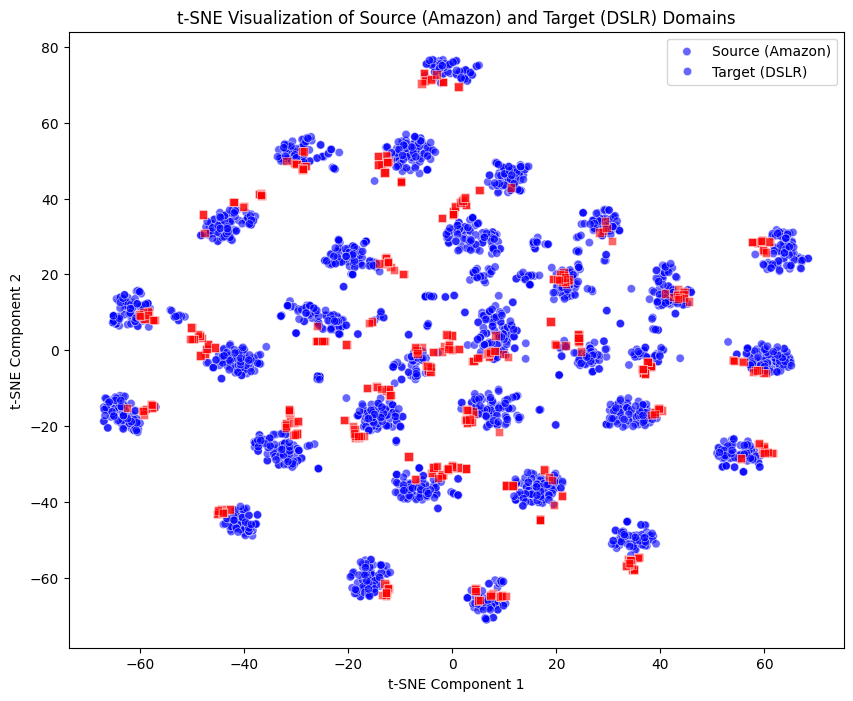

In [4]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
from tqdm import tqdm

# --- SEEDING FOR REPRODUCIBILITY ---
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# --- DATA ---
data_root = "./data"
source_domain = "amazon/images"
target_domain = "dslr/images"
batch_size = 64
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class Office31Dataset(torch.utils.data.Dataset):
    def __init__(self, root, domain, transform=None):
        self.root = os.path.join(root, domain)
        self.transform = transform
        self.images, self.labels = [], []
        label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(self.root)))
                     if os.path.isdir(os.path.join(self.root, label))}
        for label in sorted(os.listdir(self.root)):
            label_dir = os.path.join(self.root, label)
            if not os.path.isdir(label_dir): continue
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                if os.path.isdir(img_path): continue
                if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')): continue
                self.images.append(img_path)
                self.labels.append(label_map[label])
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Datasets and loaders
source_dataset = Office31Dataset(data_root, source_domain, transform=test_transform)
target_dataset = Office31Dataset(data_root, target_domain, transform=test_transform)
source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# --- MODEL ---
model = torchvision.models.resnet50(pretrained=False)
num_classes = len(set(source_dataset.labels))
model.fc = nn.Linear(2048, num_classes)
model.load_state_dict(torch.load("best_finetune_phase2_resnet50.pth", map_location=device))
model = model.to(device)
model.eval()

# --- FEATURE EXTRACTION ---
def extract_features(loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting features"):
            data = data.to(device)
            # Forward pass through the model up to avgpool
            x = model.conv1(data)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            feat = x.squeeze(-1).squeeze(-1)  # Shape: (batch_size, 2048)
            features.append(feat.cpu().numpy())
            labels.append(target.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features
source_features, source_labels = extract_features(source_loader, model, device)
target_features, target_labels = extract_features(target_loader, model, device)

# Combine features and create domain labels (0 for source, 1 for target)
all_features = np.concatenate([source_features, target_features], axis=0)
domain_labels = np.concatenate([np.zeros(len(source_features)), np.ones(len(target_features))])

# --- t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=1)
tsne_features = tsne.fit_transform(all_features)

# --- PLOT ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=domain_labels, 
                palette={0: 'blue', 1: 'red'}, style=domain_labels, markers={0: 'o', 1: 's'},
                alpha=0.6)
plt.title("t-SNE Visualization of Source (Amazon) and Target (DSLR) Domains")
plt.legend(labels=['Source (Amazon)', 'Target (DSLR)'])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.savefig("tsne_domain_plot.png")
plt.show()